In [95]:
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from numpy.linalg import multi_dot
from numpy.linalg import inv
from numpy.linalg import det
import pandas as pd
import random
import math

# Auxilary classes and methods

In [96]:
def train_test_split(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [97]:
def feature_normalize(df, mu=None, sigma=None):
    # copy the dataframe
    if df.size == 0:
        return df, None, None
    df_normalized = df.copy()
    if mu is None and sigma is None:
        mu = df_normalized.mean(axis=0)
        sigma = df_normalized.std(axis=0, ddof=1)
    df_normalized = (df_normalized - mu) / sigma
    return df_normalized, mu, sigma

In [98]:
def feature_minmax(df, min_value=None, minmax_gap=None):
    # copy the dataframe
    if df.size == 0:
        return df, None, None
    df_normalized = df.copy()
    if min_value is None and minmax_gap is None:
        min_value = df_normalized.min(axis=0)
        minmax_gap = df_normalized.max(axis=0) - df_normalized.min(axis=0)
    df_normalized = (df_normalized - min_value) / minmax_gap
    return df_normalized, min_value, minmax_gap

In [99]:
# This method transforms a group set vector into a binary group set matrix
def transform_labels(classLabels):
    new_label = np.zeros((len(classLabels), len(np.unique(classLabels))))
    for i in range(len(classLabels)):
        if classLabels[i] == 1:
            new_label[i][0] = 1
        elif classLabels[i] == 2:
            new_label[i][1] = 1
        else:
            new_label[i][2] = 1
    return new_label

In [100]:
def transform_perceptron_sign(array):
    for i in range(len(array)):
        if array[i] == 0:
            array[i] = -1
    return array

def loss(y, y_pred, type_of_loss=None, features_set=None, beta=None):
    y = np.array(y).ravel()
    y_pred = np.array(y_pred).ravel()
    if type_of_loss == 'mse':
        loss = (y - y_pred) ** 2 / len(y)
        return loss
    elif type_of_loss == '0-1':
        # binary classification
        # assume that wine type 1 is for positive, type 2 is for negative
        # however, we have to reassign the group numbers if we classify wine type 3
        if len(np.unique(y_pred)) <= 2:
            loss = np.sum(y != y_pred)
            # false positive: true 2 classified as 1
            type_i_error = np.sum(y_pred < y)
            # false negative: true 1 classified as 2
            type_ii_error = np.sum(y < y_pred)
            return loss, type_i_error, type_ii_error
        else:
            loss = np.sum(y != y_pred)
            return loss
    elif type_of_loss == 'hinge':
        loss = 0
        y = transform_perceptron_sign(y)
        y_pred = transform_perceptron_sign(y_pred)
        for i in range(len(y)):
            if y[i] * y_pred[i] < 1:
                loss += 1 - y[i] * np.dot(features_set[i].T, beta[0])
        return loss
    else: 
        message = 'type of error not specified'
        return message

# Logistic classifier

In [101]:
class LogisticClassifier():
    def __init__(self):
        self.logit_param = None
        self.class_labels = None
        self.mu = None
        self.sigma = None

    def fit(self, features_set, group_set, class_labels, alpha=0.1, num_iter=250, reg_opt = None, lambda_ = 0.01):
        complete_set = pd.concat([group_set, features_set], axis=1)
        sorted_complete_set = pd.merge(class_labels, complete_set, on='Label', sort=False)
        features_set = np.array(sorted_complete_set.iloc[:, 1:])
        features_set, self.mu, self.sigma = feature_normalize(features_set)
        group_set = np.array(sorted_complete_set.iloc[:, 0])
        class_labels = np.array(class_labels).ravel()
        sample_size = features_set.shape[0]
        self.class_labels = class_labels
        
        if len(self.class_labels) == 2:
            weight = np.zeros(features_set.shape[1])
            bias = 0
            class_labels_transform = (group_set==class_labels[0])
            for i in range(num_iter):
                sigma = 1 / (1 + np.exp(-np.dot(features_set, weight) - bias))
                if reg_opt == 'l1': # Lasso regression
                    gradient = np.dot(features_set.T, (sigma * np.ones(sample_size) - class_labels_transform)) / sample_size + lambda_ * np.sign(weight) 
                elif reg_opt == 'l2': # Ridge regression
                    gradient = np.dot(features_set.T, (sigma * np.ones(sample_size) - class_labels_transform)) / sample_size + lambda_ * weight 
                else:
                    gradient = np.dot(features_set.T, (sigma * np.ones(sample_size) - class_labels_transform)) / sample_size
                #db = np.sum(sigma - group_set) / features_set.shape[0]
                db = np.sum(sigma * np.ones(features_set.shape[0]) - (group_set==class_labels[0])) / sample_size
                weight -= alpha * gradient
                bias -= alpha * db
        else:
            weight = np.zeros((features_set.shape[1], len(np.unique(group_set))))
            bias = 0
            class_labels_transform = transform_labels(group_set)
            for i in range(num_iter):
                # sigma = np.exp(np.dot(featuresSet, weight) + bias) / 1 + np.sum(np.exp(np.dot(featuresSet, weight) + bias))
                # sigma = softmax(np.dot(features_set, weight) + bias)
                sigma = np.exp(np.dot(features_set, weight) + bias) / np.sum(np.exp(np.dot(features_set, weight) + bias), axis = 1).reshape(-1, 1)
                if reg_opt == 'l1': # Lasso regression
                    gradient = np.dot(features_set.T, (sigma - class_labels_transform)) / sample_size + lambda_ * np.sign(weight) 
                elif reg_opt == 'l2': # Ridge regression
                    gradient = np.dot(features_set.T, (sigma - class_labels_transform)) / sample_size + lambda_ * weight
                else:
                    gradient = np.dot(features_set.T, (sigma - class_labels_transform)) / sample_size
                db = np.sum(sigma - class_labels_transform) / features_set.shape[0]
                weight -= alpha * gradient
                bias -= alpha * db
        self.logit_param = weight, bias
        return self

    def predict(self, features_set):
        features_set = feature_normalize(features_set, self.mu, self.sigma)[0]
        if len(self.class_labels) == 2:
            result = 1 / (1 + np.exp(-np.dot(features_set, self.logit_param[0]) - self.logit_param[1]))
            # y_pred = np.where(result >= 0.5, 1, 0)
            y_pred = np.zeros(result.shape[0])
            for i in range(len(y_pred)):
                if result[i] >= 0.5:  # threshold = 0.5
                    y_pred[i] = self.class_labels[0]
                else:
                    y_pred[i] = self.class_labels[1]
        else:
            # result = np.exp(np.dot(featuresSet, logit_param[0]) + logit_param[1]) / 1 + np.sum(np.exp(np.dot(featuresSet, logit_param[0]) + logit_param[1]))
            # result = softmax(np.dot(features_set, self.logit_param[0]) + self.logit_param[1])
            result = np.exp(np.dot(features_set, self.logit_param[0]) + self.logit_param[1]) / np.sum(np.exp(np.dot(features_set, self.logit_param[0]) + self.logit_param[1]), axis = 1).reshape(-1, 1)
            y_pred = self.class_labels[np.argmax(result, axis=1)]
        return y_pred

# Perceptron

In [102]:
def step(features_set, weight, bias):
        z = np.dot(weight, features_set) + bias
        if z >= 0:
            return 1
        else:
            return 0
        
class Perceptron():

    def __init__(self):
        self.class_labels = None
        self.beta = None
        self.min_value = None
        self.minmax_gap = None

    def fit(self, features_set, group_set, class_labels, alpha=0.1, num_iter=250):
        complete_set = pd.concat([group_set, features_set], axis=1)
        sorted_complete_set = pd.merge(class_labels, complete_set, on='Label', sort=False)
        features_set = np.array(sorted_complete_set.iloc[:, 1:])
        features_set, self.min_value, self.minmax_gap = feature_minmax(features_set)
        group_set = np.array(sorted_complete_set.iloc[:, 0])
        class_labels = np.array(class_labels).ravel()
        self.class_labels = class_labels
        class_labels_transform = (group_set==class_labels[0])
        weight = np.zeros(features_set.shape[1])
        bias = 0
        for i in range(num_iter):
            for m in range(len(features_set)):
                y_ = step(features_set[m], weight, bias)
                for n in range(len(weight)):
                    weight[n] += alpha * (class_labels_transform[m] - y_) * features_set[m][n]
                    bias += alpha * (class_labels_transform[m] - y_)
        self.beta = weight, bias
        return self

    def predict(self, features_set):
        features_set = feature_minmax(features_set, self.min_value, self.minmax_gap)[0]
        result = np.dot(features_set, self.beta[0]) + self.beta[1]
        y_pred = np.zeros(result.shape[0])
        for i in range(len(y_pred)):
            if result[i] >= 0:
                y_pred[i] = self.class_labels[0]
            else:
                y_pred[i] = self.class_labels[1]
        return y_pred

# K nearest neighbours

In [103]:
def KNN_fit(train_sample, train_class, test, k):
    train_sample, mu, sigma = feature_normalize(train_sample)
    train_sample = np.array(train_sample)
    train_class = np.array(train_class).ravel().astype(np.int)
    test = feature_normalize(test, mu, sigma)[0]
    test = np.array(test)
    sample_size = train_sample.shape[0]
    test_size = test.shape[0]
    result = []
    for i in range(test_size):
        distance_all = []
        for j in range(sample_size):
            distance = np.sum((test[i] - train_sample[j])**2)
            distance_all.append(distance)
        neighbours_index = np.argsort(distance_all)[0 : k]
        class_counts = np.bincount(train_class[neighbours_index])
        most_frequent_class = np.argmax(class_counts)
        result.append(most_frequent_class)
    return result

# Binary classification

In [104]:
# import data
data = pd.read_csv('wine.csv', header = None)
column_names = ['Label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
                'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
                'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                'Proline']
wine = pd.DataFrame(data)
wine.columns = column_names

In [105]:
train_sample, test_sample = train_test_split(wine, 0.2)

In [106]:
# Choose predictors
train_features_set = train_sample[train_sample['Label'].isin([1, 3])][['Alcalinity of ash','Proanthocyanins']]
train_group_set = train_sample[train_sample['Label'].isin([1, 3])][['Label']]
class_labels = pd.DataFrame([1, 3], columns=['Label'])
test_features_set = test_sample[test_sample['Label'].isin([1, 3])][['Alcalinity of ash','Proanthocyanins']]
test_group_set = test_sample[test_sample['Label'].isin([1, 3])].iloc[:, 0]

In [107]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = train_features_set.iloc[:, 0].min() - .5, train_features_set.iloc[:, 0].max() + .5
    y_min, y_max = train_features_set.iloc[:, 1].min() - .5, train_features_set.iloc[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(train_features_set.iloc[:, 0], train_features_set.iloc[:, 1], c=train_group_set.values, cmap=plt.cm.Spectral)

## Logistic classifier

### Choosing regularization parameter using cross validation

#### For Lasso

In [108]:
n_train = train_features_set.shape[0]
num_fold = 5
n_fold = math.floor(n_train / num_fold)

total_error_all = []
type_i_error_all = []
type_ii_error_all = []
meshgrid = np.arange(0, 0.1, 0.01)

features_set = train_features_set
group_set = train_group_set

for lambda_ in meshgrid:
    total_error = 0
    type_i_error = 0
    type_ii_error = 0
    for cur_fold in range(num_fold):
        features_set_fold = features_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        features_set_train_fold = features_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]

        pr = LogisticClassifier().fit(features_set_train_fold, group_set_train_fold, class_labels, reg_opt='l1', lambda_ = lambda_)
        group_set_pred = pr.predict(features_set_fold)
        total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
        type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
        type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]
    total_error_all.append(total_error)
    type_i_error_all.append(type_i_error)
    type_ii_error_all.append(type_ii_error)
    
best_lambda = meshgrid[np.argsort(total_error_all)[0]]
print(best_lambda)

0.0


#### For Ridge

In [109]:
n_train = train_features_set.shape[0]
num_fold = 5
n_fold = math.floor(n_train / num_fold)

total_error_all = []
type_i_error_all = []
type_ii_error_all = []
meshgrid = np.arange(0, 0.1, 0.01)

features_set = train_features_set
group_set = train_group_set

for lambda_ in meshgrid:
    total_error = 0
    type_i_error = 0
    type_ii_error = 0
    for cur_fold in range(num_fold):
        features_set_fold = features_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        features_set_train_fold = features_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]

        pr = LogisticClassifier().fit(features_set_train_fold, group_set_train_fold, class_labels, reg_opt='l2', lambda_ = lambda_)
        group_set_pred = pr.predict(features_set_fold)
        total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
        type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
        type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]
    total_error_all.append(total_error)
    type_i_error_all.append(type_i_error)
    type_ii_error_all.append(type_ii_error)
    
best_lambda = meshgrid[np.argsort(total_error_all)[0]]
print(best_lambda)

0.0


### Training and testing error without the regularization parameter

In [110]:
lr = LogisticClassifier().fit(train_features_set, train_group_set, class_labels)
train_group_set_pred = lr.predict(train_features_set)
test_group_set_pred = lr.predict(test_features_set)

In [111]:
result = pd.Series(loss(train_group_set, train_group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      6
type_i_error     3
type_ii_error    3
dtype: int32


In [112]:
result = pd.Series(loss(test_group_set, test_group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      2
type_i_error     2
type_ii_error    0
dtype: int32


### Training and testing error for Lasso regression

In [113]:
lr = LogisticClassifier().fit(train_features_set, train_group_set, class_labels, reg_opt = 'l1', lambda_ = 0.02)
train_group_set_pred = lr.predict(train_features_set)
test_group_set_pred = lr.predict(test_features_set)

In [114]:
result = pd.Series(loss(train_group_set, train_group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      6
type_i_error     3
type_ii_error    3
dtype: int32


In [115]:
result = pd.Series(loss(test_group_set, test_group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      2
type_i_error     2
type_ii_error    0
dtype: int32


### Training and testing error for Ridge regression

In [116]:
lr = LogisticClassifier().fit(train_features_set, train_group_set, class_labels, reg_opt = 'l2', lambda_ = 0.02)
train_group_set_pred = lr.predict(train_features_set)
test_group_set_pred = lr.predict(test_features_set)

In [117]:
result = pd.Series(loss(train_group_set, train_group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      6
type_i_error     3
type_ii_error    3
dtype: int32


In [118]:
result = pd.Series(loss(test_group_set, test_group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      2
type_i_error     2
type_ii_error    0
dtype: int32


### Classification result plot

<function matplotlib.pyplot.show(close=None, block=None)>

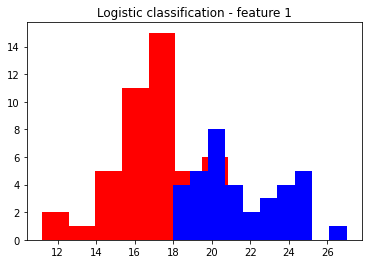

In [119]:
fig = plt.figure()

lr_plot_1 = train_features_set.iloc[:, 0]
lr_plot_2 = train_group_set_pred
lr_plot = np.column_stack((lr_plot_1, lr_plot_2))
lr_plot_x1 = lr_plot[lr_plot[:, 1] == 1]
lr_plot_x2 = lr_plot[lr_plot[:, 1] == 3]

plt.hist(lr_plot_x1[:, 0], color='red')
plt.hist(lr_plot_x2[:, 0], color='blue')

plt.title('Logistic classification - feature 1')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

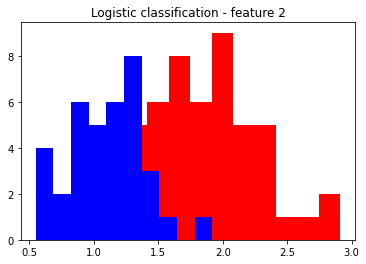

In [120]:
fig = plt.figure()

lr_plot_1 = train_features_set.iloc[:, 1]
lr_plot_2 = train_group_set_pred
lr_plot = np.column_stack((lr_plot_1, lr_plot_2))
lr_plot_x1 = lr_plot[lr_plot[:, 1] == 1]
lr_plot_x2 = lr_plot[lr_plot[:, 1] == 3]

plt.hist(lr_plot_x1[:, 0], color='red')
plt.hist(lr_plot_x2[:, 0], color='blue')

plt.title('Logistic classification - feature 2')
plt.show

Text(0.5, 1.0, 'Logistic Regression')

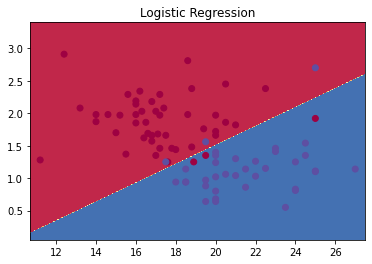

In [121]:
# Plot the decision boundary
plot_decision_boundary(lambda x: lr.predict(x))
plt.title("Logistic Regression")

## Perceptron

### Training and testing error

In [122]:
p = Perceptron().fit(train_features_set, train_group_set, class_labels)
train_group_set_pred = p.predict(train_features_set)
test_group_set_pred = p.predict(test_features_set)

In [123]:
result = pd.Series(loss(train_group_set, train_group_set_pred, 'hinge', train_features_set, p.beta), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      0
type_i_error     0
type_ii_error    0
dtype: int64


In [124]:
result = pd.Series(loss(test_group_set, test_group_set_pred, 'hinge', test_features_set, p.beta), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      0
type_i_error     0
type_ii_error    0
dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

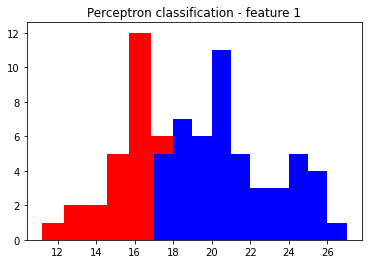

In [125]:
fig = plt.figure()

lr_plot_1 = train_features_set.iloc[:, 0]
lr_plot_2 = train_group_set_pred
lr_plot = np.column_stack((lr_plot_1, lr_plot_2))
lr_plot_x1 = lr_plot[lr_plot[:, 1] == 1]
lr_plot_x2 = lr_plot[lr_plot[:, 1] == 3]

plt.hist(lr_plot_x1[:, 0], color='red')
plt.hist(lr_plot_x2[:, 0], color='blue')

plt.title('Perceptron classification - feature 1')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

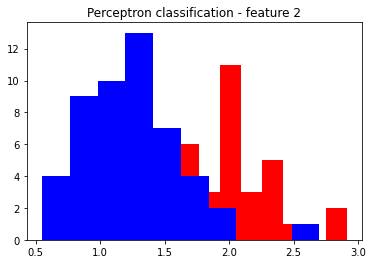

In [126]:
fig = plt.figure()

lr_plot_1 = train_features_set.iloc[:, 1]
lr_plot_2 = train_group_set_pred
lr_plot = np.column_stack((lr_plot_1, lr_plot_2))
lr_plot_x1 = lr_plot[lr_plot[:, 1] == 1]
lr_plot_x2 = lr_plot[lr_plot[:, 1] == 3]

plt.hist(lr_plot_x1[:, 0], color='red')
plt.hist(lr_plot_x2[:, 0], color='blue')

plt.title('Perceptron classification - feature 2')
plt.show

Text(0.5, 1.0, 'Perceptron')

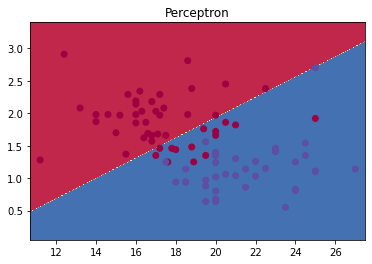

In [127]:
# Plot the decision boundary
plot_decision_boundary(lambda x: p.predict(x))
plt.title("Perceptron")

## KNN

### Choosing the number of neighbours using cross validation

In [84]:
n_train = train_features_set.shape[0]
num_fold = 10
n_fold = math.floor(n_train / num_fold)

total_error_all = []
type_i_error_all = []
type_ii_error_all = []
meshgrid = np.arange(1, 30, 1)

features_set = train_features_set
group_set = train_group_set

for k in meshgrid:
    total_error = 0
    type_i_error = 0
    type_ii_error = 0
    for cur_fold in range(num_fold):
        features_set_fold = features_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        features_set_train_fold = features_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]

        group_set_pred = KNN_fit(features_set_train_fold, group_set_train_fold, features_set_fold, k)
        total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
        type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
        type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]
    total_error_all.append(total_error)
    type_i_error_all.append(type_i_error)
    type_ii_error_all.append(type_ii_error)
    
best_k = meshgrid[np.argsort(total_error_all)[0]]
print(best_k)

29


### Training and testing error

In [85]:
train_group_pred = KNN_fit(train_features_set, train_group_set, train_features_set, 29)
test_group_pred = KNN_fit(train_features_set, train_group_set, test_features_set, 29)

In [86]:
result = pd.Series(loss(train_group_set, train_group_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      5
type_i_error     2
type_ii_error    3
dtype: int32


In [87]:
result = pd.Series(loss(test_group_set, test_group_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      3
type_i_error     3
type_ii_error    0
dtype: int32


<function matplotlib.pyplot.show(close=None, block=None)>

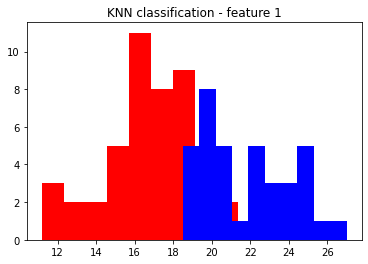

In [93]:
fig = plt.figure()

lr_plot_1 = train_features_set.iloc[:, 0]
lr_plot_2 = train_group_pred
lr_plot = np.column_stack((lr_plot_1, lr_plot_2))
lr_plot_x1 = lr_plot[lr_plot[:, 1] == 1]
lr_plot_x2 = lr_plot[lr_plot[:, 1] == 3]

plt.hist(lr_plot_x1[:, 0], color='red')
plt.hist(lr_plot_x2[:, 0], color='blue')

plt.title('KNN classification - feature 1')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

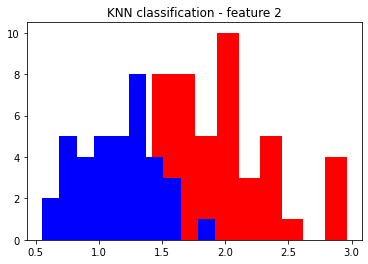

In [94]:
fig = plt.figure()

lr_plot_1 = train_features_set.iloc[:, 1]
lr_plot_2 = train_group_pred
lr_plot = np.column_stack((lr_plot_1, lr_plot_2))
lr_plot_x1 = lr_plot[lr_plot[:, 1] == 1]
lr_plot_x2 = lr_plot[lr_plot[:, 1] == 3]

plt.hist(lr_plot_x1[:, 0], color='red')
plt.hist(lr_plot_x2[:, 0], color='blue')

plt.title('KNN classification - feature 2')
plt.show

# 3-Classes classification

In [242]:
# Choose predictors
train_features_set = train_sample[['Alcohol', 'Flavanoids', 'Proanthocyanins', 'Color intensity']]
train_group_set = train_sample[['Label']]
class_labels = pd.DataFrame([1, 2, 3], columns=['Label'])
test_features_set = test_sample[['Alcohol', 'Flavanoids', 'Proanthocyanins', 'Color intensity']]
test_group_set = test_sample[['Label']]

## Logistic classifier

### Choosing regularization parameter using cross validation

#### For Lasso

In [243]:
n_train = train_features_set.shape[0]
num_fold = 5
n_fold = math.floor(n_train / num_fold)

total_error_all = []
type_i_error_all = []
type_ii_error_all = []
meshgrid = np.arange(0, 0.1, 0.01)

features_set = train_features_set
group_set = train_group_set

for lambda_ in meshgrid:
    total_error = 0
    for cur_fold in range(num_fold):
        features_set_fold = features_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        features_set_train_fold = features_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]

        pr = LogisticClassifier().fit(features_set_train_fold, group_set_train_fold, class_labels, reg_opt='l1', lambda_ = lambda_)
        group_set_pred = pr.predict(features_set_fold)
        total_error += loss(group_set_fold, group_set_pred, '0-1')
    total_error_all.append(total_error)
    
best_lambda = meshgrid[np.argsort(total_error_all)[0]]
print(best_lambda)

0.09


In [244]:
n_train = train_features_set.shape[0]
num_fold = 5
n_fold = math.floor(n_train / num_fold)

total_error_all = []
type_i_error_all = []
type_ii_error_all = []
meshgrid = np.arange(0, 0.1, 0.01)

features_set = train_features_set
group_set = train_group_set

for lambda_ in meshgrid:
    total_error = 0
    for cur_fold in range(num_fold):
        features_set_fold = features_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        features_set_train_fold = features_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]

        pr = LogisticClassifier().fit(features_set_train_fold, group_set_train_fold, class_labels, reg_opt='l2', lambda_ = lambda_)
        group_set_pred = pr.predict(features_set_fold)
        total_error += loss(group_set_fold, group_set_pred, '0-1')
    total_error_all.append(total_error)
    
best_lambda = meshgrid[np.argsort(total_error_all)[0]]
print(best_lambda)

0.0


## Training and testing error without regularization parameter

In [245]:
lr = LogisticClassifier().fit(train_features_set, train_group_set, class_labels)
train_group_set_pred = lr.predict(train_features_set)
test_group_set_pred = lr.predict(test_features_set)

In [246]:
result = pd.Series(loss(train_group_set, train_group_set_pred, '0-1'), index = ['total_error'])
print(result)

total_error    11
dtype: int64


In [247]:
result = pd.Series(loss(test_group_set, test_group_set_pred, '0-1'), index = ['total_error'])
print(result)

total_error    1
dtype: int64


# Model comparison

## Binary classification

In [255]:
# Choose predictors
train_features_set = train_sample[train_sample['Label'].isin([1, 3])][['Alcalinity of ash','Proanthocyanins']]
train_group_set = train_sample[train_sample['Label'].isin([1, 3])][['Label']]
class_labels = pd.DataFrame([1, 3], columns=['Label'])
test_features_set = test_sample[test_sample['Label'].isin([1, 3])][['Alcalinity of ash','Proanthocyanins']]
test_group_set = test_sample[test_sample['Label'].isin([1, 3])].iloc[:, 0]

### Naive Bayes Gaussian

In [256]:
# Note: the input to the methods should be pandas dataframes, especially that feature_set has to be 2-d
class NaiveBayesGaussian():
    def __init__(self):
        self.mu_params = None
        self.cov_params = None
        self.pi_params = None
        self.class_labels = None
        
    def fit(self, feature_set, group_set, class_labels):
        feature_set, self.mu, self.sigma = feature_normalize(feature_set)
        complete_set = pd.concat([group_set, feature_set], axis=1)
        sorted_complete_set = pd.merge(class_labels, complete_set, on='Label', sort=False)
        class_labels = np.array(class_labels).ravel()
        self.class_labels = class_labels
        
        self.mu_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).mean().iloc[:, 1:]
        self.cov_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).var().iloc[:, 1:]
        self.pi_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).count().iloc[:, 0] / sorted_complete_set.iloc[:, 0].count()
        
        return self
    
    def predict(self, feature_set, threshold=0.5):
        # use numpy for better performance
        feature_set = feature_normalize(feature_set, self.mu, self.sigma)[0]
        feature_set = np.array(feature_set)
        mu_params = np.array(self.mu_params)
        cov_params = np.array(self.cov_params)
        pi_params = np.array(self.pi_params)
        
        k = len(self.class_labels) # number of classes
        n = feature_set.shape[0] # sample size
        
        # Treat 1d and 2d feature set separately
        if len(feature_set.shape) == 1:
            d = 1
        else:
            d = feature_set.shape[1] # number of features
        
        # for binary classification
        if len(self.class_labels) == 2:
            group_set = np.zeros((n, 1))
            for i in range(n):
                numerator = np.zeros((1, 2))
                likelihood_0 = np.exp(- 0.5 * np.square((feature_set[i] - mu_params[0]) / np.sqrt(cov_params[0]))) / (np.sqrt(2 * np.pi) * np.sqrt(cov_params[0]))
                likelihood_1 = np.exp(- 0.5 * np.square((feature_set[i] - mu_params[1]) / np.sqrt(cov_params[1]))) / (np.sqrt(2 * np.pi) * np.sqrt(cov_params[1]))
                numerator_0 = pi_params[0] * np.prod(likelihood_0)
                numerator_1 = pi_params[1] * np.prod(likelihood_1)
                posterior_0 = numerator_0 / (numerator_0 + numerator_1)
                if posterior_0 > threshold:
                    group_set[i] = self.class_labels[0]
                else:
                    group_set[i] = self.class_labels[1]
        
        # for non-binary classification
        else:
            group_set = np.zeros((n, 1))
            for i in range(n):
                winning_class = 0
                max_prob = 0
                for r in range(k):
                    likelihood = np.exp(- 0.5 * np.square((feature_set[i] - mu_params[r]) / np.sqrt(cov_params[r]))) / (np.sqrt(2 * np.pi) * np.sqrt(cov_params[r]))
                    class_prob = pi_params[r] * np.prod(likelihood)
                    if class_prob > max_prob:
                        winning_class = r
                        max_prob = class_prob
                group_set[i] = self.class_labels[winning_class]
    
        return group_set.ravel().astype(int)

In [257]:
nbg = NaiveBayesGaussian().fit(train_features_set, train_group_set, class_labels)
train_group_set_pred = nbg.predict(train_features_set)
test_group_set_pred = nbg.predict(test_features_set)

In [258]:
result = pd.Series(loss(train_group_set, train_group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      7
type_i_error     4
type_ii_error    3
dtype: int64


In [259]:
result = pd.Series(loss(test_group_set, test_group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      2
type_i_error     0
type_ii_error    2
dtype: int64


In [260]:
meshgrid = np.linspace(0, 1, num = 100)

In [261]:
# total class 1 items
total_positive = train_group_set.groupby(train_group_set.iloc[:, 0]).count().iloc[0, 0]
# total class 2 items
total_negative = train_group_set.groupby(train_group_set.iloc[:, 0]).count().iloc[1, 0]

In [262]:
true_positive_rate_all = []
false_positive_rate_all = []
for threshold in meshgrid:
    group_set_pred = nbg.predict(train_features_set, threshold)
    type_i_error = loss(train_group_set, group_set_pred, '0-1')[1] # true 2 classified as 1
    type_ii_error = loss(train_group_set, group_set_pred, '0-1')[2] # true 1 classified as 2
    true_positive_rate = (total_positive - type_ii_error) / total_positive
    false_positive_rate = type_i_error / total_negative
    true_positive_rate_all.append(true_positive_rate)
    false_positive_rate_all.append(false_positive_rate)

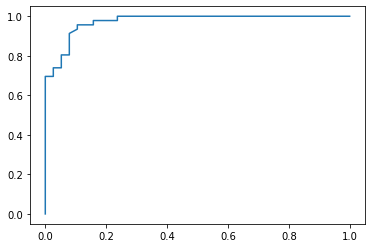

In [263]:
plt.plot(false_positive_rate_all, true_positive_rate_all, 1, 1)

### Linear Discriminant Analysis

In [264]:
# Note: the input to the methods should be pandas dataframes
class LinearDiscriminantAnalysis():
    def __init__(self):
        self.mu_params = None
        self.cov_params = None
        self.pi_params = None
        self.class_labels = None
        
    def fit(self, feature_set, group_set, class_labels):
        feature_set, self.mu, self.sigma = feature_normalize(feature_set)
        complete_set = pd.concat([group_set, feature_set], axis=1)
        sorted_complete_set = pd.merge(class_labels, complete_set, on='Label', sort=False)
        class_labels = np.array(class_labels).ravel()
        self.class_labels = class_labels
        
        self.mu_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).mean().iloc[:, 1:]
        self.cov_params = sorted_complete_set.iloc[:, 1:].cov()
        self.pi_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).count().iloc[:, 0] / sorted_complete_set.iloc[:, 0].count()
        
        return self
    
    def predict(self, feature_set, threshold=0.5):
        # use numpy for better performance
        feature_set = feature_normalize(feature_set, self.mu, self.sigma)[0]
        feature_set = np.array(feature_set)
        mu_params = np.array(self.mu_params)
        cov_params = np.array(self.cov_params)
        pi_params = np.array(self.pi_params)
        
        k = len(self.class_labels) # number of classes
        n = feature_set.shape[0] # sample size
        
        # Treat 1d and 2d feature set separately
        if len(feature_set.shape) == 1:
            d = 1
        else:
            d = feature_set.shape[1] # number of features
        
        # for binary classification
        if len(self.class_labels) == 2:
            group_set = np.zeros((n, 1))
            for i in range(n):
                numerator = np.zeros((1, 2))
                likelihood_0 = np.exp(- 0.5 * np.linalg.multi_dot([(feature_set[i] - mu_params[0]), np.linalg.inv(cov_params), np.transpose(feature_set[i] - mu_params[0])])) / (np.power(2 * np.pi, d/2) * np.sqrt(np.linalg.det(cov_params)))
                likelihood_1 = np.exp(- 0.5 * np.linalg.multi_dot([(feature_set[i] - mu_params[1]), np.linalg.inv(cov_params), np.transpose(feature_set[i] - mu_params[1])])) / (np.power(2 * np.pi, d/2) * np.sqrt(np.linalg.det(cov_params)))
                numerator_0 = pi_params[0] * likelihood_0
                numerator_1 = pi_params[1] * likelihood_1
                posterior_0 = numerator_0 / (numerator_0 + numerator_1)
                if posterior_0 > threshold:
                    group_set[i] = self.class_labels[0]
                else: 
                    group_set[i] = self.class_labels[1]
        
        # for non-binary classification
        else:
            group_set = np.zeros((n, 1))
            for i in range(n):
                winning_class = 0
                max_prob = 0
                for r in range(k):
                    likelihood = np.exp(- 0.5 * np.linalg.multi_dot([(feature_set[i] - mu_params[r]), np.linalg.inv(cov_params), np.transpose(feature_set[i] - mu_params[r])])) / (np.power(2 * np.pi, d/2) * np.sqrt(np.linalg.det(cov_params)))
                    class_prob = pi_params[r] * likelihood
                    if class_prob > max_prob:
                        winning_class = r
                        max_prob = class_prob
                group_set[i] = self.class_labels[winning_class]
        
        return group_set.ravel().astype(int)
        

In [265]:
lda = LinearDiscriminantAnalysis().fit(train_features_set, train_group_set, class_labels)
train_group_set_pred = lda.predict(train_features_set)
test_group_set_pred = lda.predict(test_features_set)

In [266]:
result = pd.Series(loss(train_group_set, train_group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      7
type_i_error     5
type_ii_error    2
dtype: int64


In [267]:
result = pd.Series(loss(test_group_set, test_group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      1
type_i_error     0
type_ii_error    1
dtype: int64


In [268]:
meshgrid = np.linspace(0, 1, num = 100)

In [269]:
# total class 1 items
total_positive = train_group_set.groupby(train_group_set.iloc[:, 0]).count().iloc[0, 0]
# total class 2 items
total_negative = train_group_set.groupby(train_group_set.iloc[:, 0]).count().iloc[1, 0]

In [270]:
true_positive_rate_all = []
false_positive_rate_all = []
for threshold in meshgrid:
    group_set_pred = lda.predict(train_features_set, threshold)
    type_i_error = loss(train_group_set, group_set_pred, '0-1')[1] # true 2 classified as 1
    type_ii_error = loss(train_group_set, group_set_pred, '0-1')[2] # true 1 classified as 2
    true_positive_rate = (total_positive - type_ii_error) / total_positive
    false_positive_rate = type_i_error / total_negative
    true_positive_rate_all.append(true_positive_rate)
    false_positive_rate_all.append(false_positive_rate)

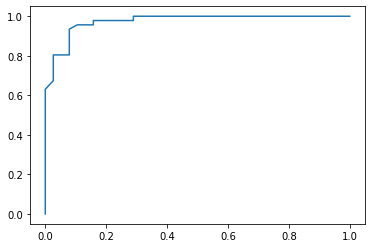

In [271]:
plt.plot(false_positive_rate_all, true_positive_rate_all, 1, 1)

### Quadratic Discriminant Analysis

In [272]:
# Note: the input to the methods should be pandas dataframes
class QuadraticDiscriminantAnalysis():
    def __init__(self):
        self.mu_params = None
        self.cov_params = None
        self.pi_params = None
        self.class_labels = None
        
    def fit(self, feature_set, group_set, class_labels):
        feature_set, self.mu, self.sigma = feature_normalize(feature_set)
        complete_set = pd.concat([group_set, feature_set], axis=1)
        sorted_complete_set = pd.merge(class_labels, complete_set, on='Label', sort=False)
        class_labels = np.array(class_labels).ravel()
        self.class_labels = class_labels
        self.mu_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).mean().iloc[:, 1:]
        cov_params = []
        for i in class_labels:
            cov_class = sorted_complete_set[sorted_complete_set.iloc[:, 0] == i].iloc[:, 1:].cov()
            cov_params.append(cov_class)
        self.cov_params = cov_params
        self.pi_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).count().iloc[:, 0] / sorted_complete_set.iloc[:, 0].count()
        
        return self
    
    def predict(self, feature_set, threshold=0.5):
        # use numpy for better performance
        feature_set = feature_normalize(feature_set, self.mu, self.sigma)[0]
        feature_set = np.array(feature_set)
        mu_params = np.array(self.mu_params)
        cov_params = np.array(self.cov_params)
        pi_params = np.array(self.pi_params)
        
        k = len(self.class_labels) # number of classes
        n = feature_set.shape[0] # sample size
        
        # Treat 1d and 2d feature set separately
        if len(feature_set.shape) == 1:
            d = 1
        else:
            d = feature_set.shape[1] # number of features
        
        # for binary classification
        if len(self.class_labels) == 2:
            group_set = np.zeros((n, 1))
            for i in range(n):
                numerator = np.zeros((1, 2))
                likelihood_0 = np.exp(- 0.5 * np.linalg.multi_dot([(feature_set[i] - mu_params[0]), np.linalg.inv(cov_params[0]), np.transpose(feature_set[i] - mu_params[0])])) / (np.power(2 * np.pi, d/2) * np.sqrt(np.linalg.det(cov_params[0])))
                likelihood_1 = np.exp(- 0.5 * np.linalg.multi_dot([(feature_set[i] - mu_params[1]), np.linalg.inv(cov_params[1]), np.transpose(feature_set[i] - mu_params[1])])) / (np.power(2 * np.pi, d/2) * np.sqrt(np.linalg.det(cov_params[1])))
                numerator_0 = pi_params[0] * likelihood_0
                numerator_1 = pi_params[1] * likelihood_1
                posterior_0 = numerator_0 / (numerator_0 + numerator_1)
                if posterior_0 > threshold: # probability threshold for classifying into the first group
                    group_set[i] = self.class_labels[0]
                else: 
                    group_set[i] = self.class_labels[1]
        
        # for non-binary classification
        else:
            group_set = np.zeros((n, 1))
            for i in range(n):
                winning_class = 0
                max_prob = 0
                for r in range(k):
                    likelihood = np.exp(- 0.5 * np.linalg.multi_dot([(feature_set[i] - mu_params[r]), np.linalg.inv(cov_params[r]), np.transpose(feature_set[i] - mu_params[r])])) / (np.power(2 * np.pi, d/2) * np.sqrt(np.linalg.det(cov_params[r])))
                    class_prob = pi_params[r] * likelihood
                    if class_prob > max_prob:
                        winning_class = r
                        max_prob = class_prob
                group_set[i] = self.class_labels[winning_class]
                
        return group_set.ravel().astype(int)

In [273]:
qda = QuadraticDiscriminantAnalysis().fit(train_features_set, train_group_set, class_labels)
train_group_set_pred = qda.predict(train_features_set)
test_group_set_pred = qda.predict(test_features_set)

In [274]:
result = pd.Series(loss(train_group_set, train_group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      6
type_i_error     4
type_ii_error    2
dtype: int64


In [275]:
result = pd.Series(loss(test_group_set, test_group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      1
type_i_error     0
type_ii_error    1
dtype: int64


In [276]:
meshgrid = np.linspace(0, 1, num = 100)

In [277]:
# total class 1 items
total_positive = train_group_set.groupby(train_group_set.iloc[:, 0]).count().iloc[0, 0]
# total class 2 items
total_negative = train_group_set.groupby(train_group_set.iloc[:, 0]).count().iloc[1, 0]

In [278]:
true_positive_rate_all = []
false_positive_rate_all = []
for threshold in meshgrid:
    group_set_pred = qda.predict(train_features_set, threshold)
    type_i_error = loss(train_group_set, group_set_pred, '0-1')[1] # true 2 classified as 1
    type_ii_error = loss(train_group_set, group_set_pred, '0-1')[2] # true 1 classified as 2
    true_positive_rate = (total_positive - type_ii_error) / total_positive
    false_positive_rate = type_i_error / total_negative
    true_positive_rate_all.append(true_positive_rate)
    false_positive_rate_all.append(false_positive_rate)

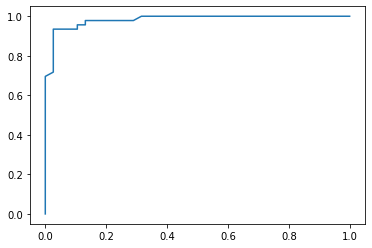

In [279]:
plt.plot(false_positive_rate_all, true_positive_rate_all, 1, 1)

## 3-Classes classification
### Naive Bayes Gaussian

In [300]:
# Choose predictors
train_features_set = train_sample[['Alcohol', 'Flavanoids', 'Proanthocyanins', 'Color intensity']]
train_group_set = train_sample[['Label']]
class_labels = pd.DataFrame([1, 2, 3], columns=['Label'])
test_features_set = test_sample[['Alcohol', 'Flavanoids', 'Proanthocyanins', 'Color intensity']]
test_group_set = test_sample[['Label']]

In [301]:
nbg = NaiveBayesGaussian().fit(train_features_set, train_group_set, class_labels)
train_group_set_pred = nbg.predict(train_features_set)
test_group_set_pred = nbg.predict(test_features_set)

In [302]:
result = pd.Series(loss(train_group_set, train_group_set_pred, '0-1'), index = ['total_error'])
print(result)

total_error    8
dtype: int64


In [303]:
result = pd.Series(loss(test_group_set, test_group_set_pred, '0-1'), index = ['total_error'])
print(result)

total_error    2
dtype: int64


### Linear Discriminant Analysis

In [304]:
lda = LinearDiscriminantAnalysis().fit(train_features_set, train_group_set, class_labels)
train_group_set_pred = lda.predict(train_features_set)
test_group_set_pred = lda.predict(test_features_set)

In [305]:
result = pd.Series(loss(train_group_set, train_group_set_pred, '0-1'), index = ['total_error'])
print(result)

total_error    11
dtype: int64


In [306]:
result = pd.Series(loss(test_group_set, test_group_set_pred, '0-1'), index = ['total_error'])
print(result)

total_error    2
dtype: int64


### Quadratic Discriminant Analysis

In [307]:
qda = QuadraticDiscriminantAnalysis().fit(train_features_set, train_group_set, class_labels)
train_group_set_pred = qda.predict(train_features_set)
test_group_set_pred = qda.predict(test_features_set)

In [308]:
result = pd.Series(loss(train_group_set, train_group_set_pred, '0-1'), index = ['total_error'])
print(result)

total_error    5
dtype: int64


In [309]:
result = pd.Series(loss(test_group_set, test_group_set_pred, '0-1'), index = ['total_error'])
print(result)

total_error    1
dtype: int64


### Comparison between Generative and Discriminative Models
When we conduct Discriminative Models, we can see very good prediction in Perceptron Model. And in general, there have no very obvious outperformance difference between Generative and Discriminative Models in our results.